In [23]:
                                                                                                                                                                                                                                                                        from math import sqrt
import numpy as np
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from pandas import read_csv
from datetime import datetime
from keras.layers import Bidirectional
import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('data/ashok_mar19_mar20.csv',index_col=0)
# dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['AT','BP','PM10','Benzene','Toluene','NH3','NO','NO2','NOx','RH','SR','WS','WD','Ozone','SO2','CO','PM2.5']
dataset.index.name = 'Date'
# mark all NA values with 0
dataset['PM2.5'].fillna(0, inplace=True)
# drop the first 24 hours
# dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')


                     AT      BP    PM10  Benzene  Toluene     NH3    NO   NO2  \
Date                                                                            
19-03-2019 00:00  23.11  986.47  222.69    53.77   176.33  149.05  0.63  7.77   
20-03-2019 00:00  25.82  984.78  223.62    47.16   149.60  130.92  0.67  7.92   
21-03-2019 00:00  24.86  988.30  178.79    50.40   164.93  116.82  0.84  6.56   
22-03-2019 00:00  23.95  990.27  126.25    40.88   188.77  208.38  0.43  2.36   
23-03-2019 00:00  24.03  989.49  148.54    44.30   181.58  197.88  0.66  2.39   

                    NOx     RH     SR     WS     WD  Ozone    SO2    CO  \
Date                                                                      
19-03-2019 00:00  33.77  27.21  48.00  77.84  80.51  42.99  31.07  1.55   
20-03-2019 00:00  24.46  30.84  23.99  59.80  51.34  49.98  23.85  1.45   
21-03-2019 00:00   9.08  36.49   3.68  32.57  19.23  55.16  25.41  1.22   
22-03-2019 00:00   6.75  27.38   2.53  40.06  22.83  56.4

(367, 17)


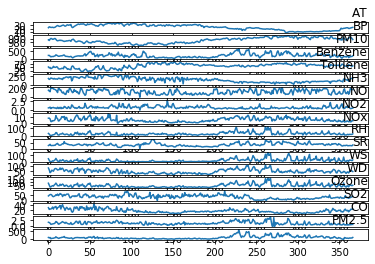

In [6]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values

print(values.shape)
# specify columns to plot
groups=[]
for i in range(values.shape[1]):
    groups.append(i)
# groups = [0, 1, 2, 3, 5, 6, 7,8,9,10,11,12,13,14,]
# print(groups)
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
#     print(group)
    pyplot.title(dataset.columns[group], y=1, loc='right')
    i += 1
# pyplot.plot(values[:,0])
# #     print(group)
# pyplot.title(dataset.columns[2], y=0.5, loc='right')
# pyplot.show()
# # values[:,0]

In [ ]:
n_hours=1
n_out= 1
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
# scaler = MinMaxScaler(feature_range=(0, 1))
# print(values.shape)
# scaled = scaler.fit_transform(values)
# print(len(scaled))
X, y = split_sequences(values, n_hours, n_out)
# for i in range(0,1):
#     print(X[i], y[i])
print(X.shape,y.shape)


In [ ]:
a=[[1,2] ,[4, 5], [6, 7]]
b=[[2 ,3] ,[5, 6], [7 ,8]]
np.flatten(a)

In [19]:
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from numpy import array


def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
    # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
    # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)






def MODEL_FNN_adam(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features):
#     train_X=train_X.flatten()
    print(train_X.shape)
    train_X=np.reshape(train_X,(train_X.shape[0],n_hours*n_features))
    test_X=np.reshape(test_X,(test_X.shape[0],n_hours*n_features))
    val_X=np.reshape(val_X,(val_X.shape[0],n_hours*n_features))
    model = Sequential()
    model.add(Dense(256, input_dim=train_X.shape[1], activation='relu'))
    model.add(Dense(1, activation='relu'))
    model.add(Dense(n_out, activation='sigmoid'))
    # compile the keras model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit the keras model on the dataset
    model.fit(train_X, train_y, epochs=200, batch_size=20, validation_data=(val_X, val_y), verbose=0, shuffle=False)
    yhat11 = model.predict(test_X, verbose=0)
    print("RMSE error using ",n_hours," state size to predict ",n_out," step is =", np.sqrt(((np.sum((yhat11-test_y)**2,axis=0)))))
    return(np.sqrt(((np.sum((yhat11-test_y)**2,axis=0)))))

def MODEL_FNN_sgd(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features):
#     train_X=train_X.flatten()
    print(train_X.shape)
    train_X=np.reshape(train_X,(train_X.shape[0],n_hours*n_features))
    test_X=np.reshape(test_X,(test_X.shape[0],n_hours*n_features))
    val_X=np.reshape(val_X,(val_X.shape[0],n_hours*n_features))
    model = Sequential()
    model.add(Dense(256, input_dim=train_X.shape[1], activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(n_out, activation='sigmoid'))
    # compile the keras model
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    # fit the keras model on the dataset
    model.fit(train_X, train_y, epochs=200, batch_size=20, validation_data=(val_X, val_y), verbose=0, shuffle=False)
    yhat11 = model.predict(test_X, verbose=0)
    print("RMSE error using ",n_hours," state size to predict ",n_out," step is =", np.sqrt(((np.sum((yhat11-test_y)**2,axis=0)))))
    return(np.sqrt(((np.sum((yhat11-test_y)**2,axis=0)))))



def MODEL_LSTM(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features):
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_hours,n_features)))

    model.add(LSTM(100, activation='relu'))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse')
# fit model
    model.fit(train_X, train_y, epochs=200, batch_size=20, validation_data=(val_X, val_y), verbose=0, shuffle=False)
    yhat11 = model.predict(test_X, verbose=0)
    print("RMSE error using ",n_hours," state size to predict ",n_out," step is =", np.sqrt(((np.sum((yhat11-test_y)**2,axis=0)))))
    return(np.sqrt(((np.sum((yhat11-test_y)**2,axis=0)))))

def MODEL_Bi_LSTM(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features):
    model = Sequential()
    model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_hours,n_features))))

    model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_hours,n_features))))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse')
# fit model
    model.fit(train_X, train_y, epochs=200, batch_size=20, validation_data=(val_X, val_y), verbose=0, shuffle=False)
    yhat11 = model.predict(test_X, verbose=0)
    print("RMSE error using ",n_hours," state size to predict ",n_out," step is =", np.sqrt(((np.sum((yhat11-test_y)**2,axis=0)))))
    return(np.sqrt(((np.sum((yhat11-test_y)**2,axis=0)))))


def MODEL_EN_DC(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features):
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))
    val_y = val_y.reshape((val_y.shape[0], val_y.shape[1], 1))
    model = Sequential()
    model.add(LSTM(200, activation='relu',input_shape=(n_hours,n_features)))
    model.add(RepeatVector(n_out))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
#     model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mse')
# fit model
    model.fit(train_X, train_y, epochs=200, batch_size=20, validation_data=(val_X, val_y), verbose=0, shuffle=False)
    yhat11 = model.predict(test_X, verbose=0)
    print("RMSE error using ",n_hours," state size to predict ",n_out," step is =", np.sqrt(((np.sum((yhat11-test_y)**2,axis=0)))))
    return(np.sqrt(((np.sum((yhat11-test_y)**2,axis=0)))))

def main(n_out_max,n_hour_max):
    dataset = read_csv('pollution.csv', header=0, index_col=0)
    values = dataset.values  
    values = values.astype('float32')
# normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    print(values.shape)
    scaled = scaler.fit_transform(values)
    print(len(scaled))
    result=np.zeros((n_out_max,n_hour_max),dtype=np.float32)
    for n_out in range (1,n_out_max+1):
        for n_hours in range(1,n_hour_max+1):
            print("Number of steps predicted= ",n_out,"Number of steps Multivariate threads ussed= ",n_hours)
            X, y = split_sequences(scaled, n_hours, n_out)
            train_X, train_y = X[0:300,:,:], y[0:300,:]
            val_X, val_y = X[300:330,:,:], y[300:330,:]
            test_X, test_y = X[330:,:,:], y[330:,:]
            print("train_X.shape, train_y.shape, test_X.shape, test_y.shape=",train_X.shape, train_y.shape, test_X.shape, test_y.shape)
            print("val X, val y",val_X.shape, val_y.shape)
            n_features = X.shape[2]
            error=MODEL(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features)
            result[n_out-1,n_hours-1]=error
      
    return result
            
            
            
            
n_out_max,n_hour_max= 10,5

# r5=main(5,10)


In [47]:
import datetime
out_range=[10]
# result=np.zeros((len(out_range),10),dtype=np.float32)
result= []
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
for i,k in enumerate(out_range):
    for j in range(1,31):
        for m in range(10,11):
            n_out=k
            n_hours=m
            print("Number of steps predicted= ",n_out,"Number of steps Multivariate threads ussed= ",n_hours, "iteration number= ",j)
            
            X, y = split_sequences(values, n_hours, n_out)
            train_X, train_y = X[0:300,:,:], y[0:300,:]
            val_X, val_y = X[300:330,:,:], y[300:330,:]
            test_X, test_y = X[330:,:,:], y[330:,:]
            print("train_X.shape, train_y.shape, test_X.shape, test_y.shape=",train_X.shape, train_y.shape, test_X.shape, test_y.shape)
            print("val X, val y",val_X.shape, val_y.shape)
            n_features = X.shape[2]
            error=MODEL_FNN_sgd(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features)
#             result[i,m-1]=result[i,m-1]+error
            result.append(error)
            
        
result=np.array(result)
np.savetxt("10i_"+str(result.shape[1])+"o_FNN_sgd_"+str(result.shape[0])+"i.csv"+str(datetime.datetime.now()), result, delimiter=",")

Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  1
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (300, 10, 16) (300, 10) (19, 10, 16) (19, 10)
val X, val y (30, 10, 16) (30, 10)
(300, 10, 16)
RMSE error using  10  state size to predict  10  step is = [387.38992 386.06677 386.27948 382.13718 373.2235  358.7292  327.5439
 313.1072  314.1312  328.78326]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  2
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (300, 10, 16) (300, 10) (19, 10, 16) (19, 10)
val X, val y (30, 10, 16) (30, 10)
(300, 10, 16)
RMSE error using  10  state size to predict  10  step is = [383.57205 389.9043  386.27948 378.31195 373.2235  358.7292  327.5439
 317.05396 310.18298 324.85   ]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  3
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (300, 10, 16) 

RMSE error using  10  state size to predict  10  step is = [383.57205 389.9043  390.11786 382.13718 377.02603 354.89905 327.5439
 317.05396 310.18298 328.78326]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  22
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (300, 10, 16) (300, 10) (19, 10, 16) (19, 10)
val X, val y (30, 10, 16) (30, 10)
(300, 10, 16)
RMSE error using  10  state size to predict  10  step is = [387.38992 386.06677 386.27948 378.31195 373.2235  354.89905 327.5439
 317.05396 314.1312  324.85   ]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  23
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (300, 10, 16) (300, 10) (19, 10, 16) (19, 10)
val X, val y (30, 10, 16) (30, 10)
(300, 10, 16)
RMSE error using  10  state size to predict  10  step is = [383.57205 386.06677 390.11786 382.13718 373.2235  354.89905 327.5439
 317.05396 310.18298 324.85   ]
Number of

In [48]:
result= []
for i,k in enumerate(out_range):
    for j in range(1,31):
        for m in range(10,11):
            n_out=k
            n_hours=m
            print("Number of steps predicted= ",n_out,"Number of steps Multivariate threads ussed= ",n_hours, "iteration number= ",j)
            
            X, y = split_sequences(values, n_hours, n_out)
            train_X, train_y = X[0:300,:,:], y[0:300,:]
            val_X, val_y = X[300:330,:,:], y[300:330,:]
            test_X, test_y = X[330:,:,:], y[330:,:]
            print("train_X.shape, train_y.shape, test_X.shape, test_y.shape=",train_X.shape, train_y.shape, test_X.shape, test_y.shape)
            print("val X, val y",val_X.shape, val_y.shape)
            n_features = X.shape[2]
            error=MODEL_FNN_adam(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features)
#             result[i,m-1]=result[i,m-1]+error
            result.append(error)
            
        
result=np.array(result)
np.savetxt("10i_"+str(result.shape[1])+"o_FNN_adam_"+str(result.shape[0])+"i.csv"+str(datetime.datetime.now()), result, delimiter=",")

Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  1
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (300, 10, 16) (300, 10) (19, 10, 16) (19, 10)
val X, val y (30, 10, 16) (30, 10)
(300, 10, 16)
RMSE error using  10  state size to predict  10  step is = [383.57205 386.06677 386.27948 382.13718 373.2235  358.7292  323.62256
 317.05396 310.18298 328.78326]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  2
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (300, 10, 16) (300, 10) (19, 10, 16) (19, 10)
val X, val y (30, 10, 16) (30, 10)
(300, 10, 16)
RMSE error using  10  state size to predict  10  step is = [383.87106 386.36682 386.57983 378.61237 373.5227  355.20135 323.93277
 313.419   310.4941  325.16202]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  3
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (300, 10, 16

RMSE error using  10  state size to predict  10  step is = [383.8711  386.36682 386.57983 378.61246 373.52274 355.20135 323.93277
 313.419   310.49426 325.16214]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  22
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (300, 10, 16) (300, 10) (19, 10, 16) (19, 10)
val X, val y (30, 10, 16) (30, 10)
(300, 10, 16)
RMSE error using  10  state size to predict  10  step is = [383.87125 386.36707 386.5801  378.6127  373.52298 355.2016  323.933
 313.41925 310.4942  325.16193]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  23
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (300, 10, 16) (300, 10) (19, 10, 16) (19, 10)
val X, val y (30, 10, 16) (30, 10)
(300, 10, 16)
RMSE error using  10  state size to predict  10  step is = [383.87106 386.36682 386.5798  378.61243 373.5227  355.20135 323.93277
 313.41898 310.49426 325.1621 ]
Number o

In [49]:
result= []
for i,k in enumerate(out_range):
    for j in range(1,31):
        for m in range(10,11):
            n_out=k
            n_hours=m
            print("Number of steps predicted= ",n_out,"Number of steps Multivariate threads ussed= ",n_hours, "iteration number= ",j)
            
            X, y = split_sequences(values, n_hours, n_out)
            train_X, train_y = X[0:300,:,:], y[0:300,:]
            val_X, val_y = X[300:330,:,:], y[300:330,:]
            test_X, test_y = X[330:,:,:], y[330:,:]
            print("train_X.shape, train_y.shape, test_X.shape, test_y.shape=",train_X.shape, train_y.shape, test_X.shape, test_y.shape)
            print("val X, val y",val_X.shape, val_y.shape)
            n_features = X.shape[2]
            error=MODEL_LSTM(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features)
#             result[i,m-1]=result[i,m-1]+error
            result.append(error)
            
        
result=np.array(result)
np.savetxt("10i_"+str(result.shape[1])+"o_LSTM_"+str(result.shape[0])+"i.csv"+str(datetime.datetime.now()), result, delimiter=",")

Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  1
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (300, 10, 16) (300, 10) (19, 10, 16) (19, 10)
val X, val y (30, 10, 16) (30, 10)
RMSE error using  10  state size to predict  10  step is = [215.54549 342.58215 367.6543  435.77356 559.8589  605.30176 656.4486
 674.4117  639.278   599.19885]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  2
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (300, 10, 16) (300, 10) (19, 10, 16) (19, 10)
val X, val y (30, 10, 16) (30, 10)
RMSE error using  10  state size to predict  10  step is = [217.78125 256.9566  290.81662 340.74503 329.7615  362.59036 404.91302
 398.95602 394.24207 424.5707 ]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  3
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (300, 10, 16) (300, 10) (19, 10, 16) (19,

RMSE error using  10  state size to predict  10  step is = [151.49574 197.19626 336.70407 445.0462  516.0888  651.0958  705.2869
 787.2254  835.01514 785.39343]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  22
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (300, 10, 16) (300, 10) (19, 10, 16) (19, 10)
val X, val y (30, 10, 16) (30, 10)
RMSE error using  10  state size to predict  10  step is = [277.4561  311.56    390.72586 453.48254 456.02597 471.92224 530.5342
 497.8926  528.78815 509.46347]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  23
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (300, 10, 16) (300, 10) (19, 10, 16) (19, 10)
val X, val y (30, 10, 16) (30, 10)
RMSE error using  10  state size to predict  10  step is = [121.574814 207.92027  294.1932   391.37854  484.41556  535.7079
 598.4142   732.47125  733.5393   839.6819  ]
Number of steps predicted=  

In [50]:
result= []
for i,k in enumerate(out_range):
    for j in range(1,31):
        for m in range(10,11):
            n_out=k
            n_hours=m
            print("Number of steps predicted= ",n_out,"Number of steps Multivariate threads ussed= ",n_hours, "iteration number= ",j)
            
            X, y = split_sequences(values, n_hours, n_out)
            train_X, train_y = X[0:300,:,:], y[0:300,:]
            val_X, val_y = X[300:330,:,:], y[300:330,:]
            test_X, test_y = X[330:,:,:], y[330:,:]
            print("train_X.shape, train_y.shape, test_X.shape, test_y.shape=",train_X.shape, train_y.shape, test_X.shape, test_y.shape)
            print("val X, val y",val_X.shape, val_y.shape)
            n_features = X.shape[2]
            error=MODEL_Bi_LSTM(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features)
#             result[i,m-1]=result[i,m-1]+error
            result.append(error)
            
        
result=np.array(result)
np.savetxt("10i_"+str(result.shape[1])+"o_bi_LSTM_"+str(result.shape[0])+"i.csv"+str(datetime.datetime.now()), result, delimiter=",")

Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  1
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (300, 10, 16) (300, 10) (19, 10, 16) (19, 10)
val X, val y (30, 10, 16) (30, 10)
RMSE error using  10  state size to predict  10  step is = [350.10065 350.82465 355.4957  360.53345 443.39603 499.04346 574.0942
 536.21265 562.34735 587.9698 ]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  2
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (300, 10, 16) (300, 10) (19, 10, 16) (19, 10)
val X, val y (30, 10, 16) (30, 10)
RMSE error using  10  state size to predict  10  step is = [242.601   275.85132 272.73218 285.46713 287.74667 293.76083 325.48157
 324.10138 364.13583 367.08865]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  3
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (300, 10, 16) (300, 10) (19, 10, 16) (19,

RMSE error using  10  state size to predict  10  step is = [351.04132 338.1119  364.5389  401.05463 417.00516 446.75836 455.35205
 454.09955 398.85635 468.19785]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  22
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (300, 10, 16) (300, 10) (19, 10, 16) (19, 10)
val X, val y (30, 10, 16) (30, 10)
RMSE error using  10  state size to predict  10  step is = [455.48367 447.34167 459.85516 504.9604  490.32996 507.22058 577.583
 597.422   647.0139  573.8491 ]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  23
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (300, 10, 16) (300, 10) (19, 10, 16) (19, 10)
val X, val y (30, 10, 16) (30, 10)
RMSE error using  10  state size to predict  10  step is = [232.882   280.82623 354.5433  435.21243 485.46478 508.49585 557.2129
 622.20325 643.5375  628.98944]
Number of steps predicted=  10 Number

In [51]:
result1= []
for i,k in enumerate(out_range):
    for j in range(1,31):
        for m in range(10,11):
            n_out=k
            n_hours=m
            print("Number of steps predicted= ",n_out,"Number of steps Multivariate threads ussed= ",n_hours, "iteration number= ",j)
            
            X, y = split_sequences(values, n_hours, n_out)
            train_X, train_y = X[0:300,:,:], y[0:300,:]
            val_X, val_y = X[300:330,:,:], y[300:330,:]
            test_X, test_y = X[330:,:,:], y[330:,:]
            print("train_X.shape, train_y.shape, test_X.shape, test_y.shape=",train_X.shape, train_y.shape, test_X.shape, test_y.shape)
            print("val X, val y",val_X.shape, val_y.shape)
            n_features = X.shape[2]
            error=MODEL_EN_DC(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features)
#             result[i,m-1]=result[i,m-1]+error
            result1.append(error)
            
        
result1=np.array(result1)
print(result1.shape)
print(result1)
result1=result1.reshape(result1.shape[0],result1.shape[1])
np.savetxt("10i_"+str(result1.shape[1])+"o_EN_DC_"+str(result1.shape[0])+"i.csv"+str(datetime.datetime.now()), result1, delimiter=",")

Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  1
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (300, 10, 16) (300, 10) (19, 10, 16) (19, 10)
val X, val y (30, 10, 16) (30, 10)
RMSE error using  10  state size to predict  10  step is = [[273.2293 ]
 [309.63495]
 [365.88354]
 [407.51627]
 [421.2245 ]
 [449.5258 ]
 [478.27936]
 [502.07404]
 [533.83093]
 [534.942  ]]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  2
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (300, 10, 16) (300, 10) (19, 10, 16) (19, 10)
val X, val y (30, 10, 16) (30, 10)
RMSE error using  10  state size to predict  10  step is = [[179.85439]
 [275.0325 ]
 [325.39322]
 [385.81174]
 [413.72342]
 [432.9008 ]
 [465.96677]
 [491.67422]
 [529.30255]
 [563.5531 ]]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  3
train_X.shape, train_y.shape, test_X.shape

RMSE error using  10  state size to predict  10  step is = [[178.83865]
 [184.39026]
 [208.92305]
 [222.82388]
 [223.92635]
 [211.23883]
 [207.76364]
 [202.01944]
 [234.99974]
 [253.38896]]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  21
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (300, 10, 16) (300, 10) (19, 10, 16) (19, 10)
val X, val y (30, 10, 16) (30, 10)
RMSE error using  10  state size to predict  10  step is = [[163.28493]
 [209.6828 ]
 [290.353  ]
 [330.33328]
 [337.4822 ]
 [331.54245]
 [346.21585]
 [381.25922]
 [426.71625]
 [454.3757 ]]
Number of steps predicted=  10 Number of steps Multivariate threads ussed=  10 iteration number=  22
train_X.shape, train_y.shape, test_X.shape, test_y.shape= (300, 10, 16) (300, 10) (19, 10, 16) (19, 10)
val X, val y (30, 10, 16) (30, 10)
RMSE error using  10  state size to predict  10  step is = [[228.6161 ]
 [258.6574 ]
 [307.35004]
 [354.95825]
 [359.88   ]
 [349.26752]
 [3

In [ ]:
import matplotlib.pyplot as plt
# n_out_max=3
xlist = np.linspace(1, n_out_max, n_out_max)
ylist = np.linspace(1, n_out_max, n_out_max)
X, Y = np.meshgrid(xlist, ylist)
# Z = np.sqrt(X**2 + Y**2)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, r)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Number of steps used in multivariate analysis x ')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('Number of steps predicted y')
plt.show()
print("Normalized RMSE Test")

In [ ]:
out_range=[1]
# result=np.zeros((len(out_range),10),dtype=np.float32)
result1= []
for i,k in enumerate(out_range):
    for j in range(1,31):
        for m in range(10,11):
            n_out=k
            n_hours=m
            print("Number of steps predicted= ",n_out,"Number of steps Multivariate threads ussed= ",n_hours, "iteration number= ",j)
            X, y = split_sequences(scaled, n_hours, n_out)
            train_X, train_y = X[0:300,:,:], y[0:300,:]
            val_X, val_y = X[300:330,:,:], y[300:330,:]
            test_X, test_y = X[330:,:,:], y[330:,:]
            print("train_X.shape, train_y.shape, test_X.shape, test_y.shape=",train_X.shape, train_y.shape, test_X.shape, test_y.shape)
            print("val X, val y",val_X.shape, val_y.shape)
            n_features = X.shape[2]
            error=MODEL(train_X,test_X,train_y,test_y,val_X,val_y,n_out,n_hours,n_features)
#             result[i,m-1]=result[i,m-1]+error
            result1.append(error)
            
        
result1



            
            
            
    
    
            
            

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
def show_results(r,method):
    x = datetime.datetime.now()
    u=np.mean(r,axis=0)
    sigma=np.std(r,axis=0)
    lower_bar= u-1.96*(sigma/(np.sqrt(r.shape[0])))
    upper_bar= u+1.96*(sigma/(np.sqrt(r.shape[0])))
    barWidth = 0.3
    bars1=u
    rl= np.arange(len(bars1))+1
    plt.bar(rl, bars1, width = barWidth, color = 'red', edgecolor = 'black', yerr=1.96*(sigma/(np.sqrt(r.shape[0]))), capsize=7, label=method+' with using 10 multivariate steps for 30 iterations')
    plt.ylabel('mean of normalized RMSE for 30 iterations')
    plt.xlabel('Number of steps')
    plt.legend()
    plt.show()
    np.savetxt("10i_"+str(r.shape[1])+"o_"+method+"_"+str(r.shape[0])+"i"+str(datetime.datetime.now())+".csv", r, delimiter=",")
# show_results(r1_new)

(29, 10)


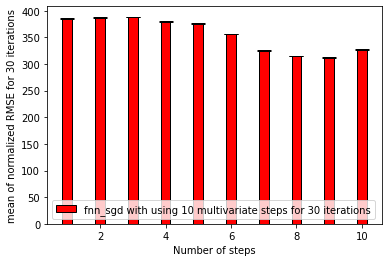

In [62]:
dsgd=read_csv('10i_10o_FNN_sgd_30i.csv2020-05-10 10:11:04_184384.csv')
dSGD = dsgd.values
print(dSGD.shape)
show_results(dSGD,'fnn_sgd')

(29, 10)


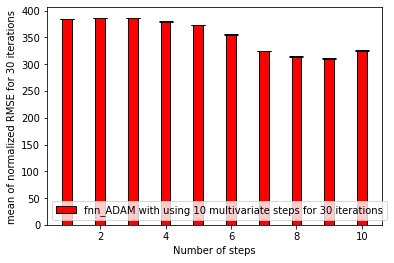

In [64]:
dadam=read_csv('10i_10o_FNN_adam_30i.csv2020-05-10 10:24:42_853842.csv')
dADAM = dadam.values
print(dADAM.shape)
show_results(dADAM,'fnn_ADAM')


(29, 10)


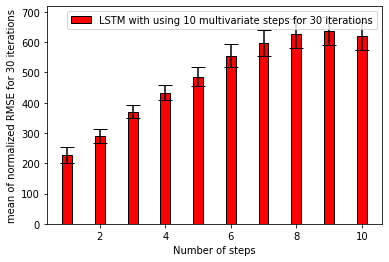

In [65]:
dlstm=read_csv('10i_10o_LSTM_30i.csv2020-05-10 11:03:02_243465.csv')
dLSTM = dlstm.values
print(dLSTM.shape)
show_results(dLSTM,'LSTM')

(29, 10)


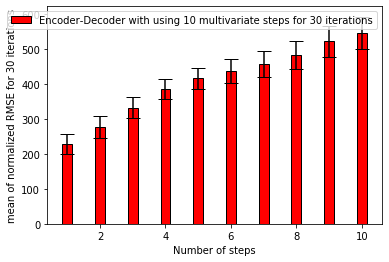

In [70]:
den=read_csv('10i_10o_EN_DC_30i.csv2020-05-10 15:40:39_077980.csv')
dEN = den.values
print(dEN.shape)
show_results(dEN,'Encoder-Decoder')

(29, 10)


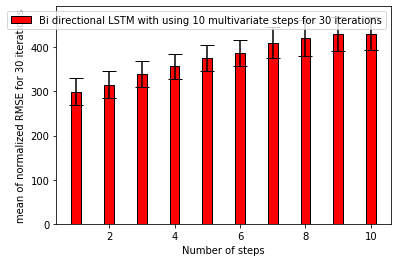

In [71]:
dbi=read_csv('10i_10o_bi_LSTM_30i.csv2020-05-10 12:29:07_591213.csv')
dBI = dbi.values
print(dBI.shape)
show_results(dBI,'Bi directional LSTM')

(29, 10)


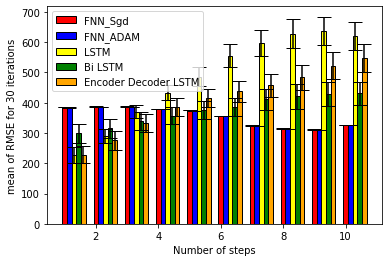

In [85]:
def show_results_Combined(r1,r2,r3,r4,r5):
    x = datetime.datetime.now()
    print(r1.shape)
    u1=np.mean(r1,axis=0)
    u2=np.mean(r2,axis=0)
    u3=np.mean(r3,axis=0)
    u4=np.mean(r4,axis=0)
    u5=np.mean(r5,axis=0)
    sigma1=np.std(r1,axis=0)
    sigma2=np.std(r2,axis=0)
    sigma3=np.std(r3,axis=0)
    sigma4=np.std(r4,axis=0)
    sigma5=np.std(r5,axis=0)
#     lower_bar= u-1.96*(sigma/(np.sqrt(r.shape[0])))
#     upper_bar= u+1.96*(sigma/(np.sqrt(r.shape[0])))
    barWidth = 0.15
    bars1=u1
    bars2=u2
    bars3=u3
    bars4=u4
    bars5=u5
    ra1= np.arange(len(bars1))+1
    ra2 = [y + barWidth for y in ra1]
    ra3 = [y + barWidth for y in ra2]
    ra4 = [y + barWidth for y in ra3]
    ra5 = [y + barWidth for y in ra4]

    plt.bar(ra1, bars1, width = barWidth, color = 'red', edgecolor = 'black', yerr=1.96*(sigma1/(np.sqrt(r1.shape[0]))), capsize=7, label='FNN_Sgd')
    plt.bar(ra2, bars2, width = barWidth, color = 'blue', edgecolor = 'black', yerr=1.96*(sigma2/(np.sqrt(r2.shape[0]))), capsize=7, label='FNN_ADAM')
    plt.bar(ra3, bars3, width = barWidth, color = 'yellow', edgecolor = 'black', yerr=1.96*(sigma3/(np.sqrt(r3.shape[0]))), capsize=7, label='LSTM')
    plt.bar(ra4, bars4, width = barWidth, color = 'green', edgecolor = 'black', yerr=1.96*(sigma4/(np.sqrt(r4.shape[0]))), capsize=7, label='Bi LSTM')
    plt.bar(ra5, bars5, width = barWidth, color = 'orange', edgecolor = 'black', yerr=1.96*(sigma5/(np.sqrt(r5.shape[0]))), capsize=7, label='Encoder Decoder LSTM')
    

    plt.ylabel('mean of RMSE for 30 iterations')
    plt.xlabel('Number of steps')
    plt.legend()
    plt.show()
#     np.savetxt("10i_"+str(r.shape[1])+"o_"+method+"_"+str(r.shape[0])+"i"+str(datetime.datetime.now())+".csv", r, delimiter=",")
show_results_Combined(dSGD,dADAM,dLSTM,dBI,dEN)